In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys
import os
import random
import pandas as pd
import pickle

import pymc3 as pm
import exoplanet as xo
import theano.tensor as T
import scipy

import caustic as ca

random.seed(42)

mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['axes.titlesize'] = 22

# Print library version numbers
print("Numpy version", np.__version__)
print("PyMC3 version", pm.__version__)

%config InlineBackend.figure_format = 'retina'

Numpy version 1.17.2
PyMC3 version 3.7


# Load traces of all fitted events into memory

In [2]:
def load_samples(data_path, params):
    samples_list = []
    samples_logp_list = []
    map_params_list = []
    n_events = 0
    for directory in os.listdir(data_path):
        n_events += 1
        path = data_path + directory 
        
        # Load trace and MAP parameters
        if os.path.exists(path + '/model_albrow/trace.csv'):
            trace = pd.read_csv(path + '/model_albrow/trace.csv')
            for param in params:
                if param not in trace.columns.tolist():
                    raise ValueError("Parameter not found in the trace file." )       

            if os.path.exists(path + '/model_albrow/MAP_params.pkl'):
                with open(path + "/model_albrow/MAP_params.pkl", "rb") as input_file:
                    p = pickle.load(input_file)
                map_params_list.append([p['ln_A0'], p['ln_delta_t0'], p['ln_tE']])
                samples_list.append(trace[params].values)
                samples_logp_list.append(trace[['logp_' + param for param in params]].values)
            else:
                print("max likelihood fitting failed for event", directory)
            
        elif os.path.exists(path + '/model_albrow/trace_diverging.csv'):
            print("Divergent samples in directory ", directory)
            
        else:
            print("Trace not found in directory", directory)
    
    print("Total number of events: ", n_events)
            
    return np.stack(samples_list, axis=0), np.stack(samples_logp_list, axis=0), np.array(map_params_list)

samples, samples_logp, map_params = load_samples('../../output_data.nosync/2002/', ['ln_A0', 'ln_delta_t0', 'ln_tE', 'f'])

Trace not found in directory OGLE-2002-BLG-048
Trace not found in directory OGLE-2002-BLG-012
Trace not found in directory OGLE-2002-BLG-078
Trace not found in directory OGLE-2002-BLG-038
Trace not found in directory OGLE-2002-BLG-031
Trace not found in directory OGLE-2002-BLG-052
Trace not found in directory OGLE-2002-BLG-090
Trace not found in directory OGLE-2002-BLG-154
Trace not found in directory OGLE-2002-BLG-016
Trace not found in directory OGLE-2002-BLG-042
Trace not found in directory OGLE-2002-BLG-045
Trace not found in directory OGLE-2002-BLG-019
Trace not found in directory OGLE-2002-BLG-278
Trace not found in directory OGLE-2002-BLG-240
Trace not found in directory OGLE-2002-BLG-088
Trace not found in directory OGLE-2002-BLG-066
Trace not found in directory OGLE-2002-BLG-059
max likelihood fitting failed for event OGLE-2003-BLG-171
Trace not found in directory OGLE-2002-BLG-262
Trace not found in directory OGLE-2002-BLG-057
Trace not found in directory OGLE-2002-BLG-209
Tr

In [3]:
print("Number of events for which fitting succeeded: ", len(samples))

Number of events for which fitting succeeded:  319


For the directories where the trace was not found the alert time was not defined.

# Classical analysis

## $\ln A_0$ distribution

Text(0.5, 0, 'median $\\ln \\,A_0$')

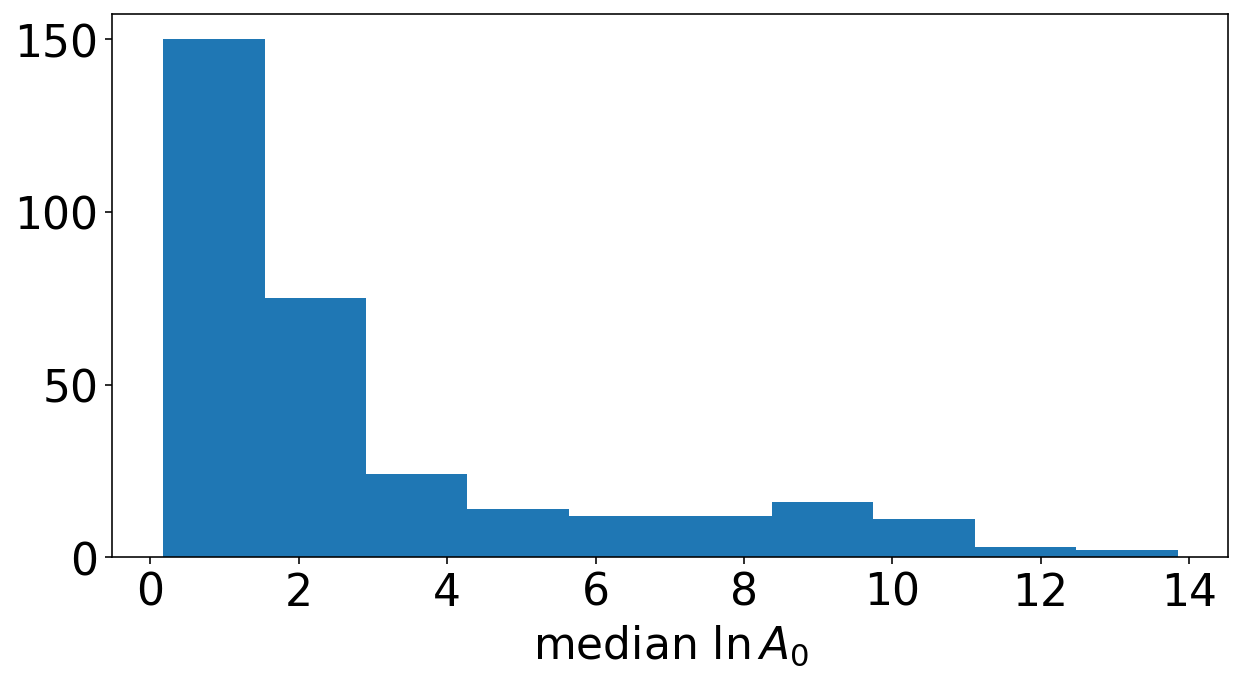

In [4]:
# Plot histograms 
fig, ax = plt.subplots(figsize=(10, 5))

medians_ln_A0 = np.median(samples[:, :, 0], axis=1)

ax.hist(medians_ln_A0, bins=10);
ax.set_xlabel('median $\ln \,A_0$')

In [5]:
import scipy
scipy.stats.expon.fit(medians_ln_A0)

(0.17043939407723901, 2.768552051287857)

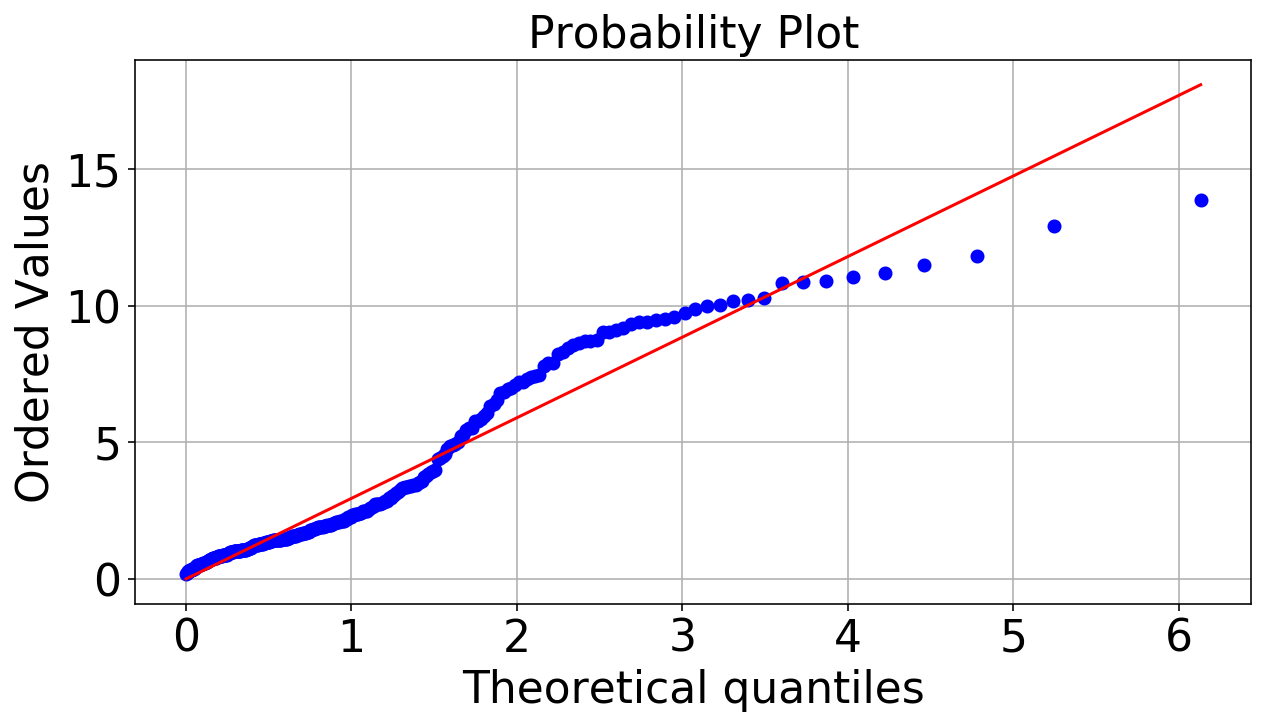

In [6]:
# q-q plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()
scipy.stats.probplot(medians_ln_A0, dist=scipy.stats.expon, plot=ax, fit=False);

## $\ln\Delta t_0$

Text(0.5, 0, 'median $\\ln\\Delta t_0$')

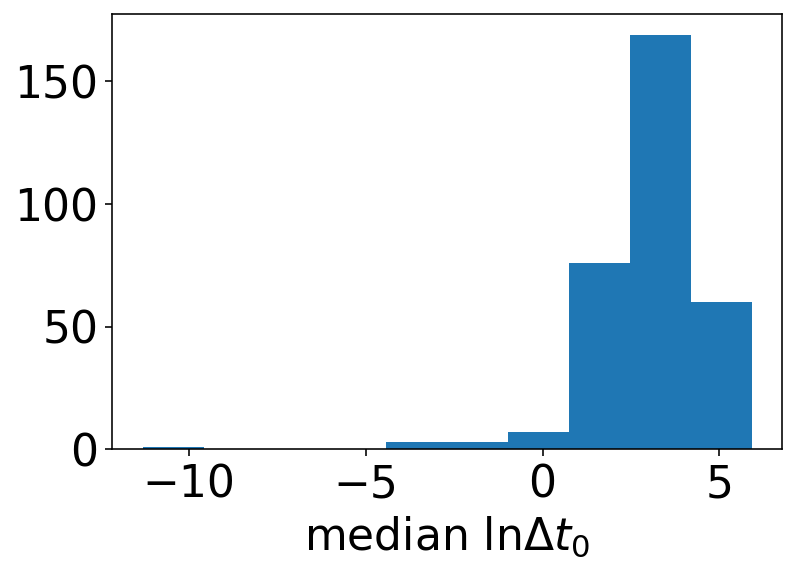

In [7]:
fig, ax = plt.subplots()

# t_0
medians_ln_delta_t0 = np.median(samples[:, :, 1], axis=1)

ax.hist(medians_ln_delta_t0, bins=10)
ax.set_xlabel('median $\ln\Delta t_0$')

In [8]:
scipy.stats.norm.fit(medians_ln_delta_t0)

(3.004778054039976, 1.630466012091119)

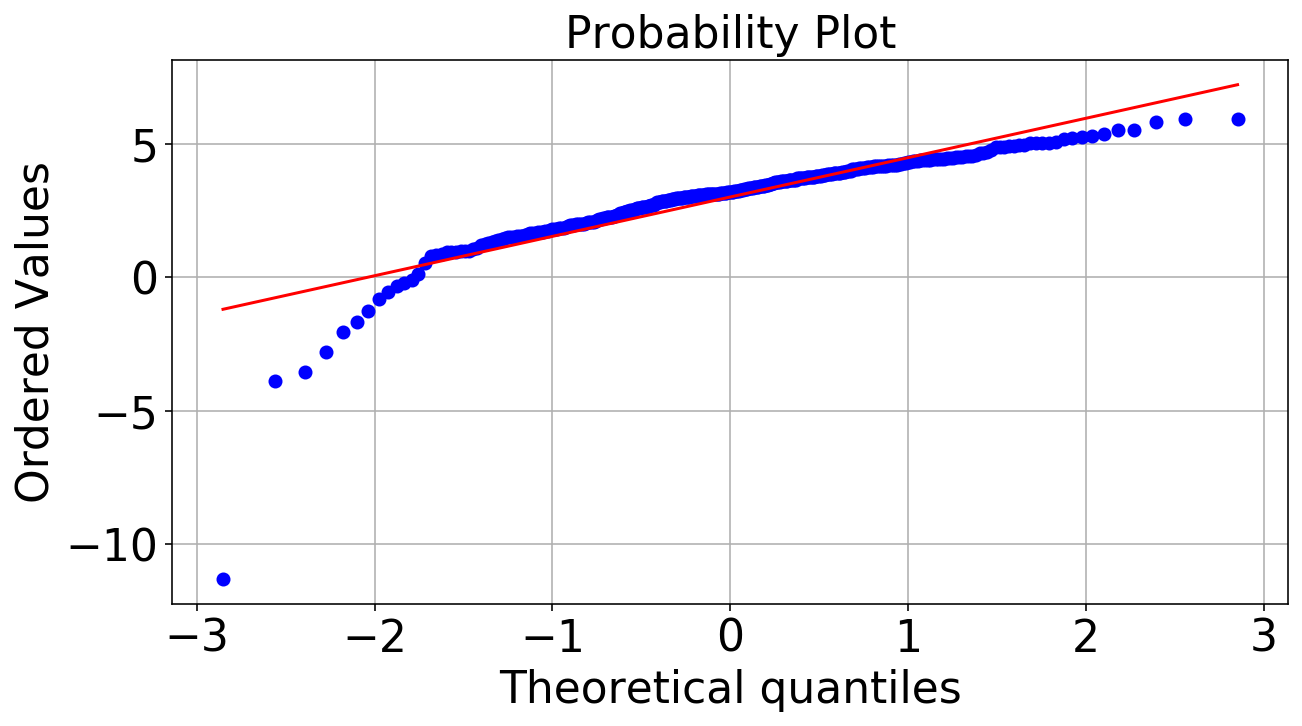

In [9]:
# q-q plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()
scipy.stats.probplot(medians_ln_delta_t0, dist=scipy.stats.norm, plot=ax, fit=False);

## $\ln t_E$

Text(0.5, 0, 'median $\\ln\\,t_E$')

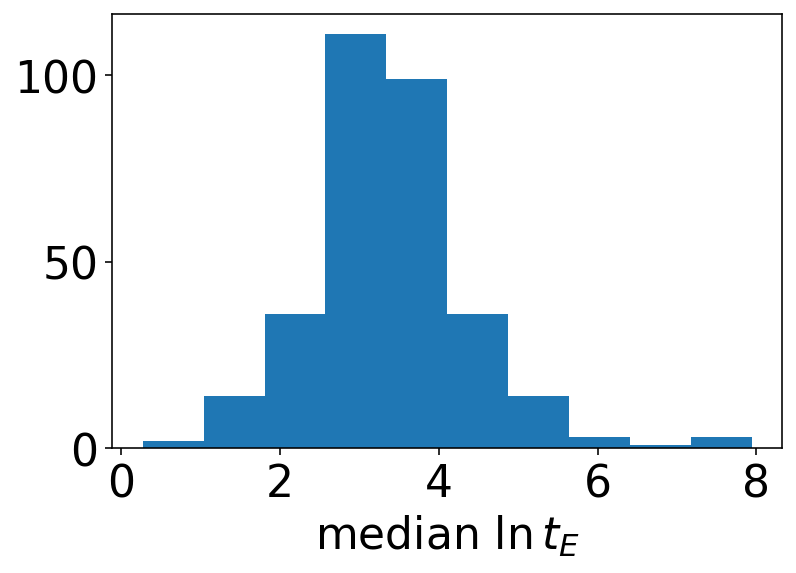

In [10]:
fig, ax = plt.subplots()

# ln_tE
medians_ln_tE = np.median(samples[:, :, 2], axis=1)
ax.hist(medians_ln_tE, bins=10);
ax.set_xlabel('median $\ln\,t_E$')

In [11]:
scipy.stats.norm.fit(medians_ln_tE)

(3.379654440406982, 0.9711328536061263)

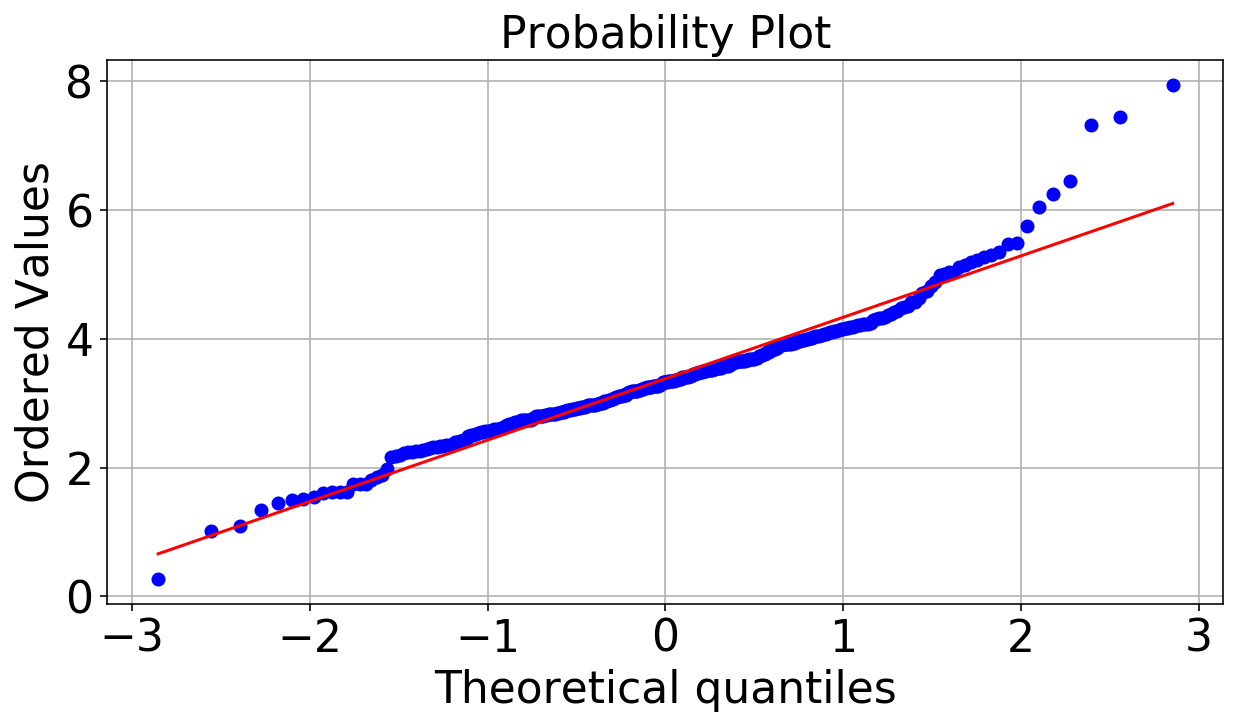

In [12]:
# q-q plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()
scipy.stats.probplot(medians_ln_tE, dist=scipy.stats.norm, plot=ax, fit=False);

## f - the fraction of blended light

Text(0.5, 0, 'median $f$')

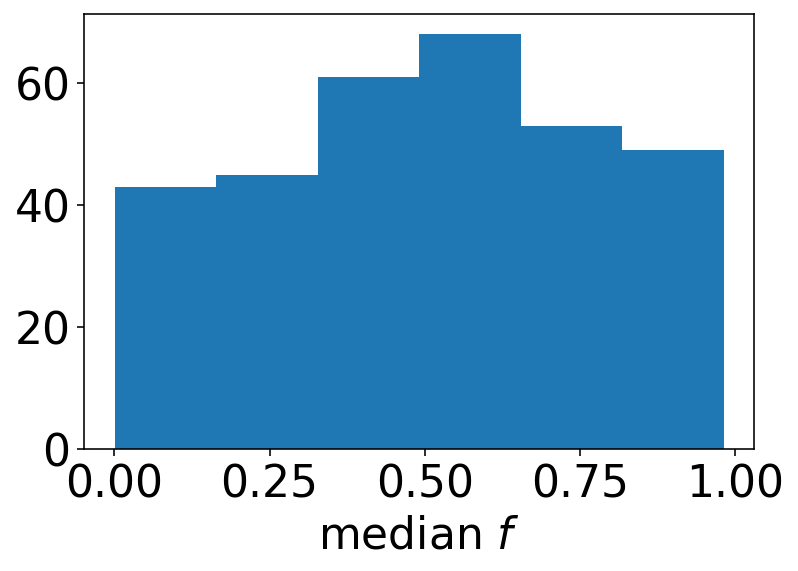

In [13]:
fig, ax = plt.subplots()

# ln_tE
medians_f = np.median(samples[:, :, 3], axis=1)
ax.hist(medians_f, bins=6);
ax.set_xlabel('median $f$')

## Pairplot for median estimates of all parameters

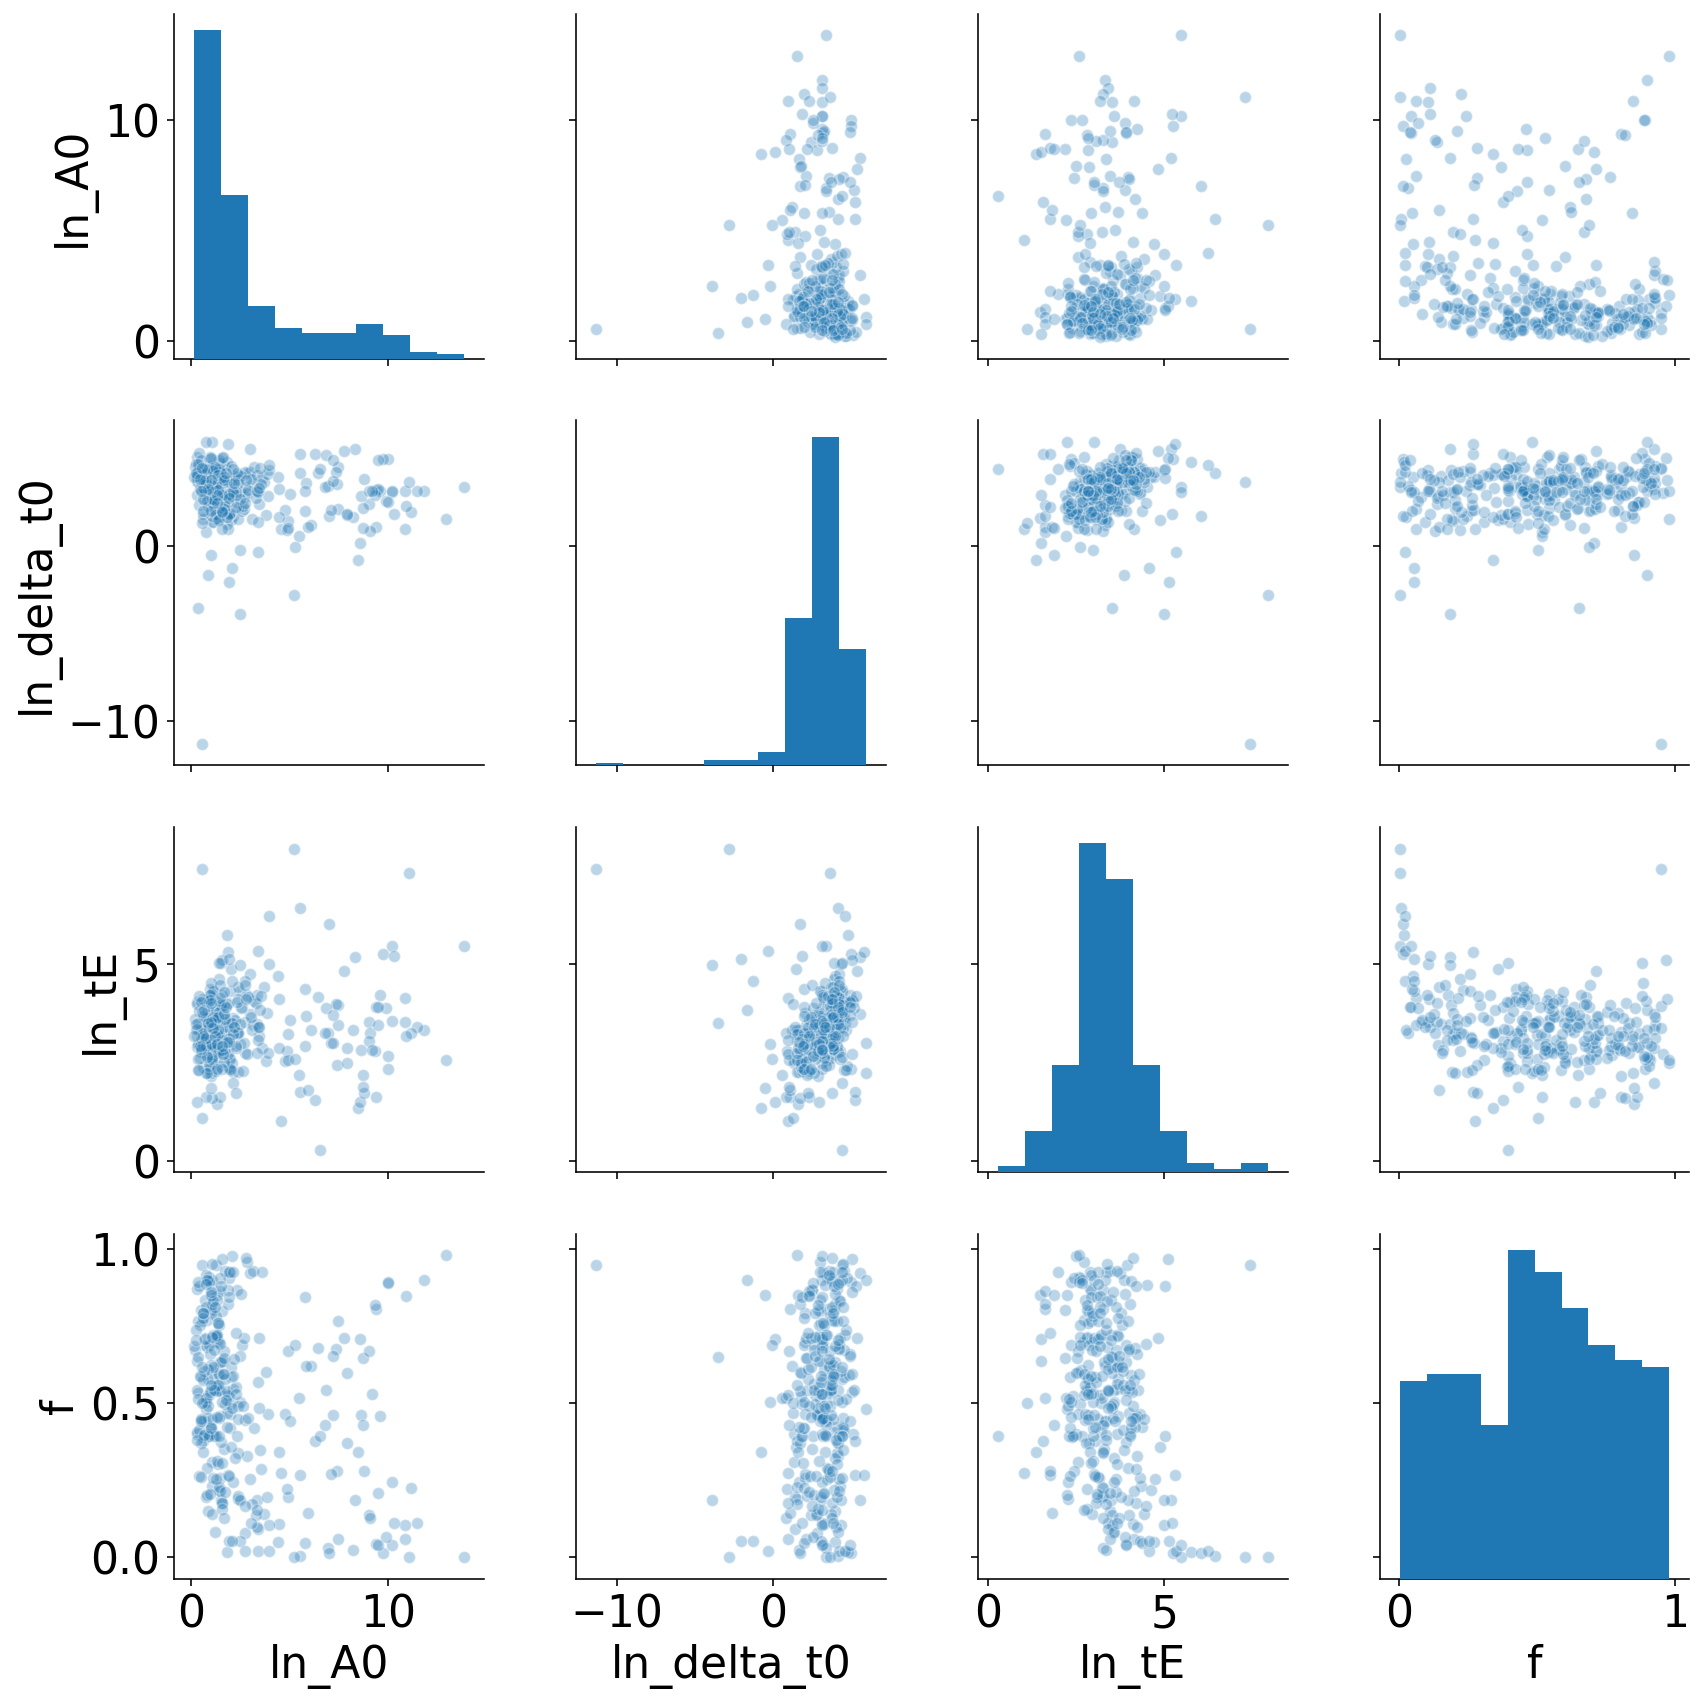

In [34]:
df = pd.DataFrame(np.stack([medians_ln_A0, medians_ln_delta_t0, medians_ln_tE, medians_f]).T,
                 columns=['ln_A0', 'ln_delta_t0', 'ln_tE', 'f'])


import seaborn as sns

sns.pairplot(df, height=3., plot_kws={'alpha':0.3})

# Load max-likelihood estimates from fitting the model on full light curves

In [14]:
array = map_params[:, 0]
mask = array < 40

## $\ln A_0$ distribution

Text(0.5, 0, 'Max likelihood $\\ln \\,A_0$')

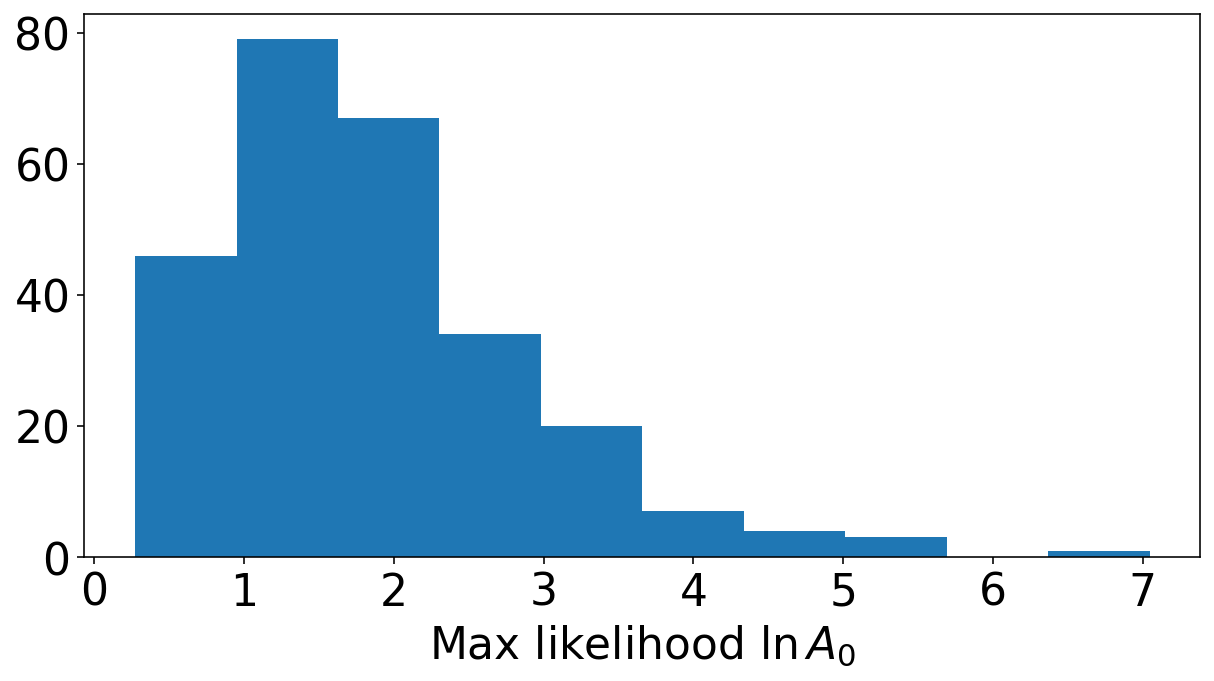

In [15]:
# Plot histograms 
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(map_params[:, 0][mask], bins=10);
ax.set_xlabel('Max likelihood $\ln \,A_0$')

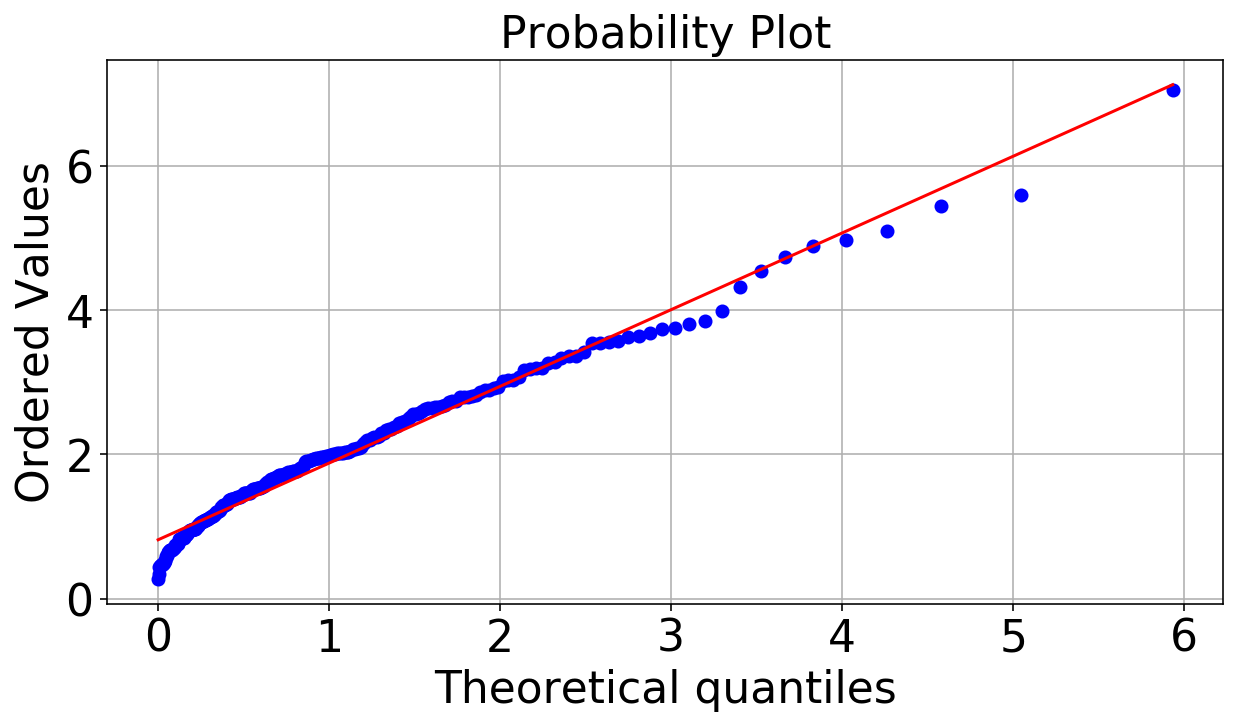

In [16]:
# q-q plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()
scipy.stats.probplot(map_params[:, 0][mask], dist=scipy.stats.expon, plot=ax, fit=False);

In [17]:
_, param = scipy.stats.expon.fit(map_params[:, 0][mask])
lam_ln_A0 = 1/param
lam_ln_A0

0.6256999815055168

## $\ln\Delta t_0$

Text(0.5, 0, 'Max likelihood $\\ln \\Delta t_0$')

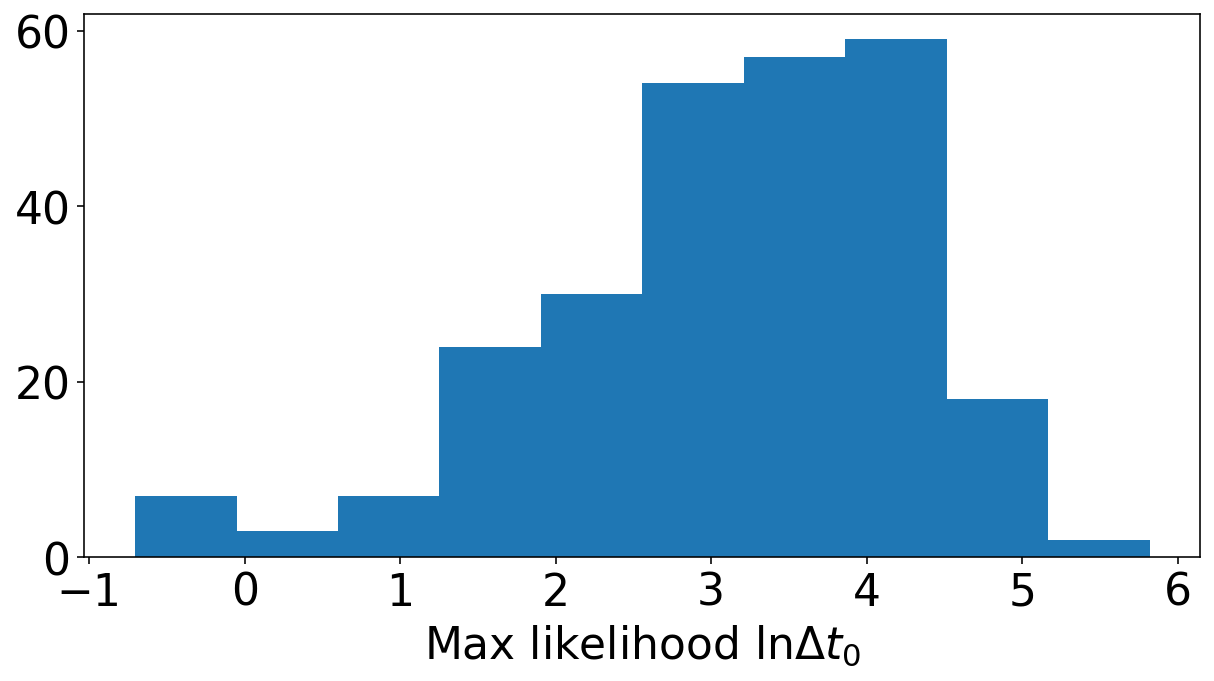

In [18]:
# Plot histograms 
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(map_params[:, 1][mask], bins=10);
ax.set_xlabel('Max likelihood $\ln \Delta t_0$')

In [19]:
mu_ln_delta_t0, sig_ln_delta_t0 = scipy.stats.norm.fit(map_params[:, 1][mask])

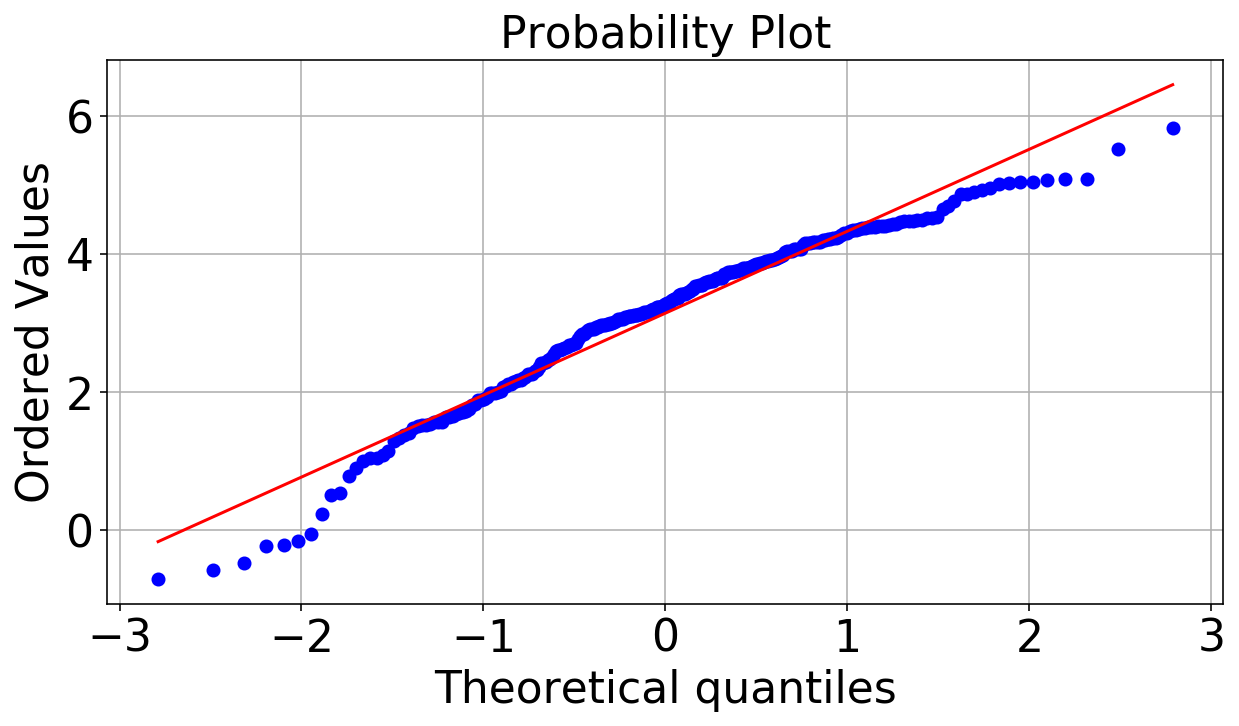

In [20]:
# q-q plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()
scipy.stats.probplot(map_params[:, 1][mask], dist=scipy.stats.norm, plot=ax, fit=False);

## $\ln t_E$

Text(0.5, 0, 'Max likelihood $\\ln t_E$')

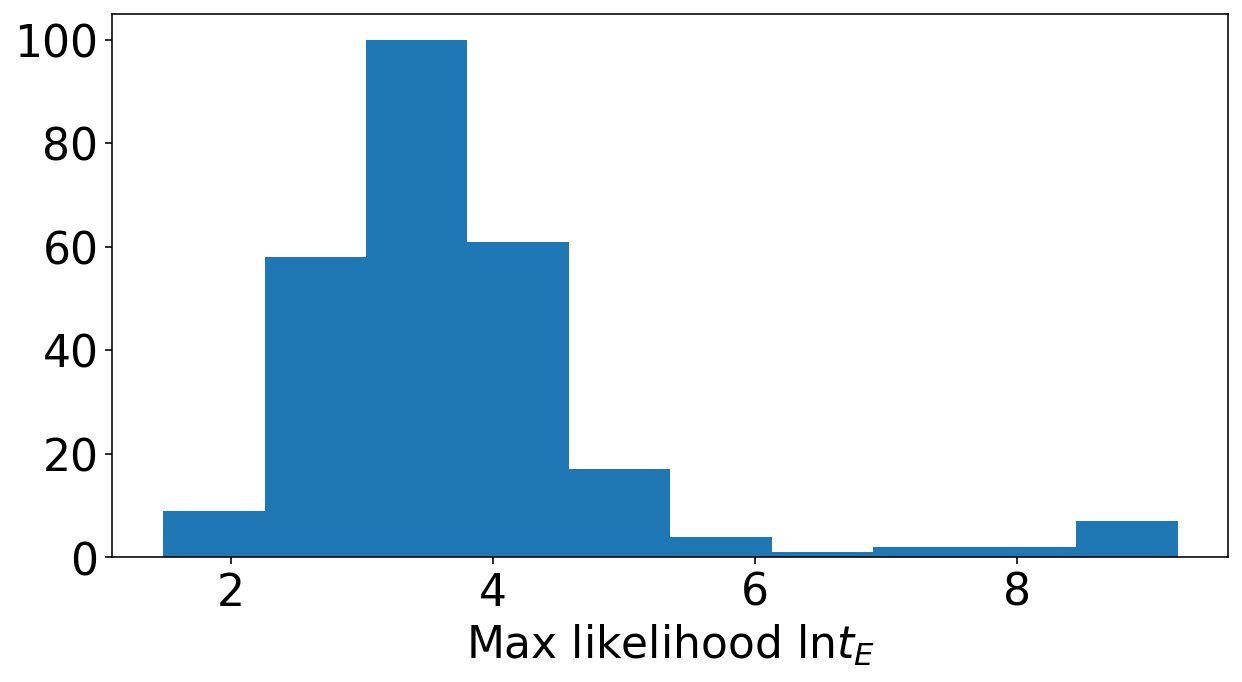

In [21]:
# Plot histograms 
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(map_params[:, 2][mask], bins=10);
ax.set_xlabel('Max likelihood $\ln t_E$')

In [22]:
mu_ln_tE, sig_ln_tE = scipy.stats.norm.fit(map_params[:, 2][mask])

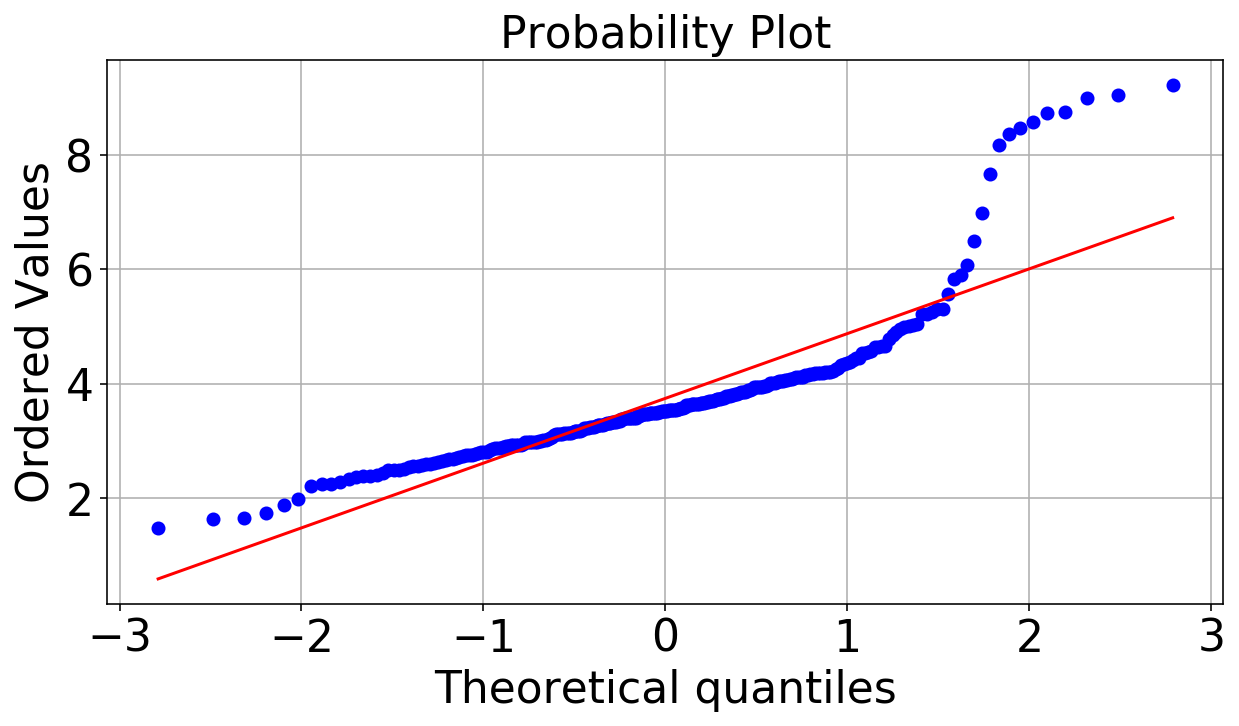

In [23]:
# q-q plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()
scipy.stats.probplot(map_params[:, 2][mask], dist=scipy.stats.norm, plot=ax, fit=False);

# Load samples from the hierarchical model

In [27]:
# Full samples produced on a cluster, my laptop doesn't have enough memory to handle all the samples
samples_hyper = np.load('../data/samples_hyper.npy') # lam_ln_A0, mu_deltat0, sig_deltat0, mu_lntE, sig_lntE
np.shape(samples_hyper)

(4000, 7)

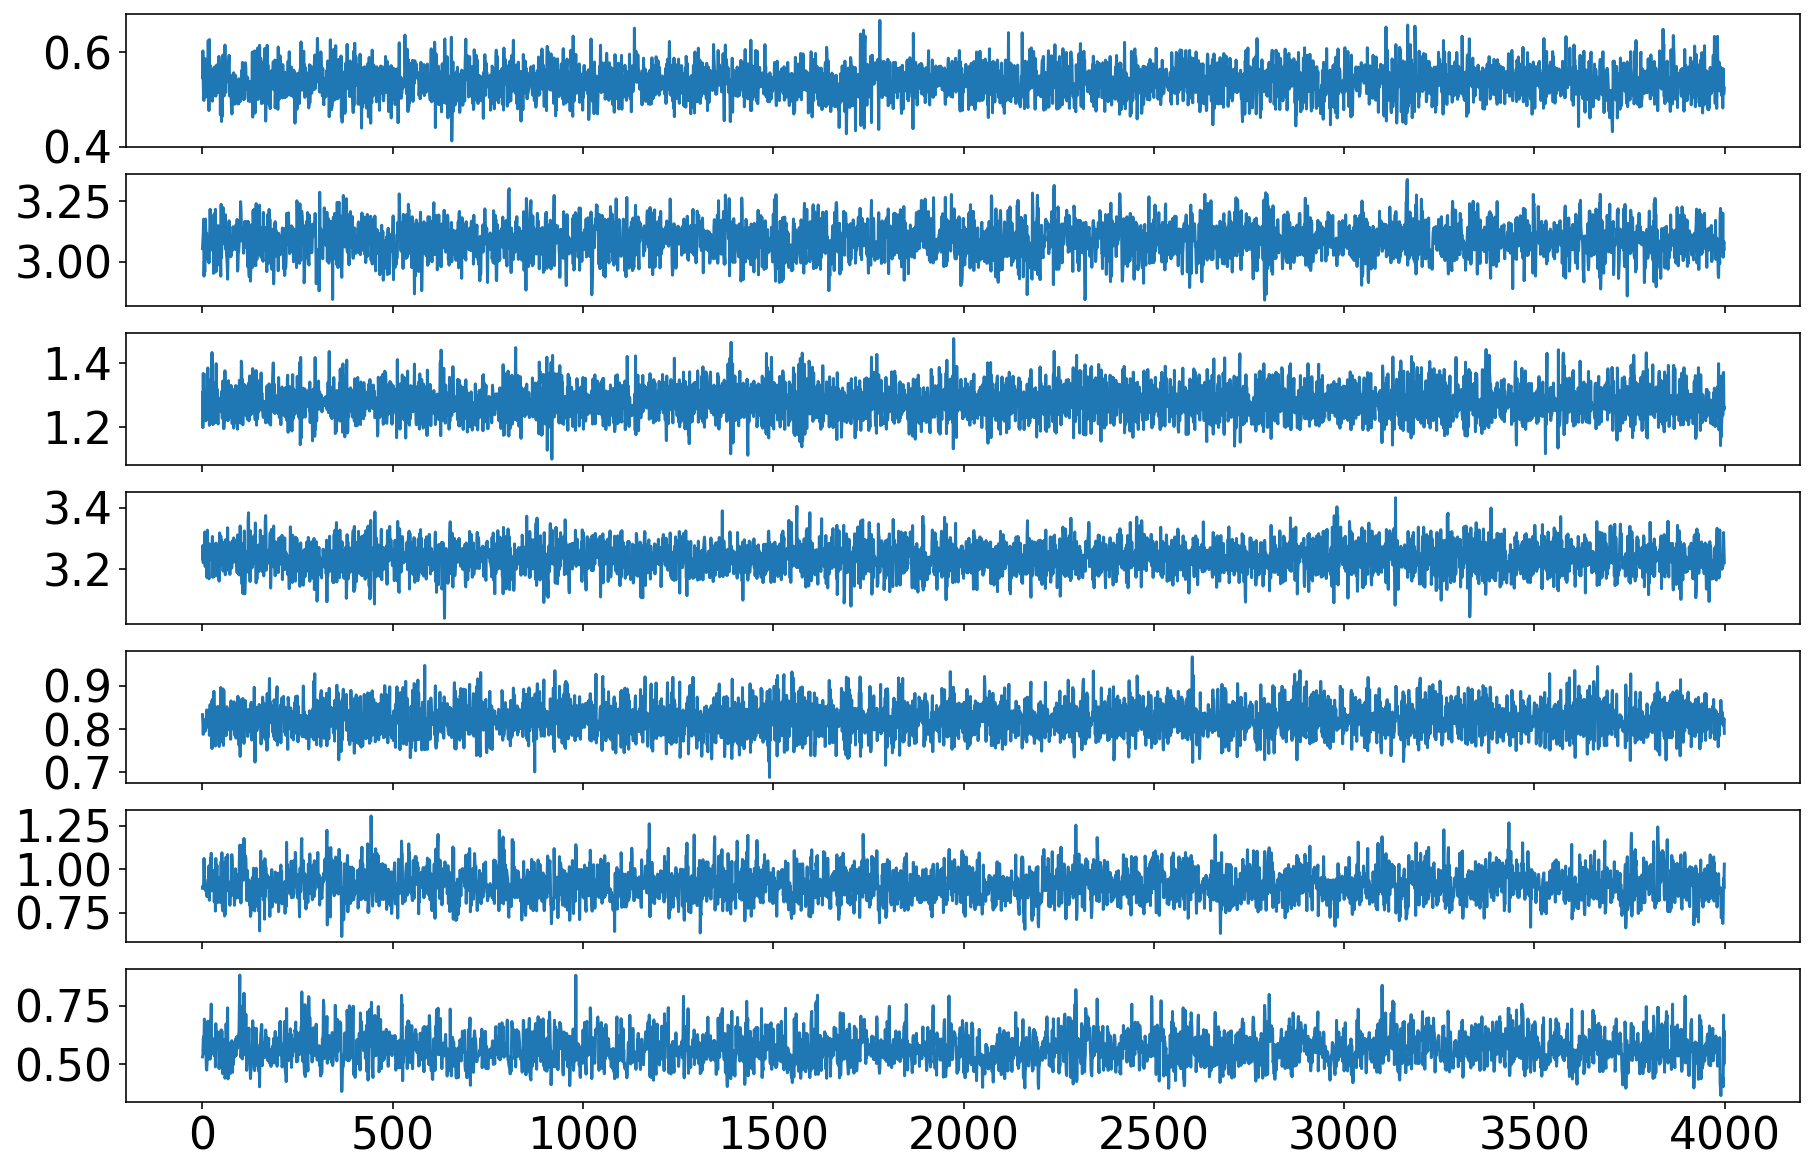

In [28]:
# Plot chains
fig, ax = plt.subplots(7, 1, figsize=(15,10), sharex=True)

for i, a in enumerate(ax.ravel()):
    a.plot(samples_hyper[:, i])

(0, 10)

/Users/fb90/anaconda3/envs/pymc3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/fb90/anaconda3/envs/pymc3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


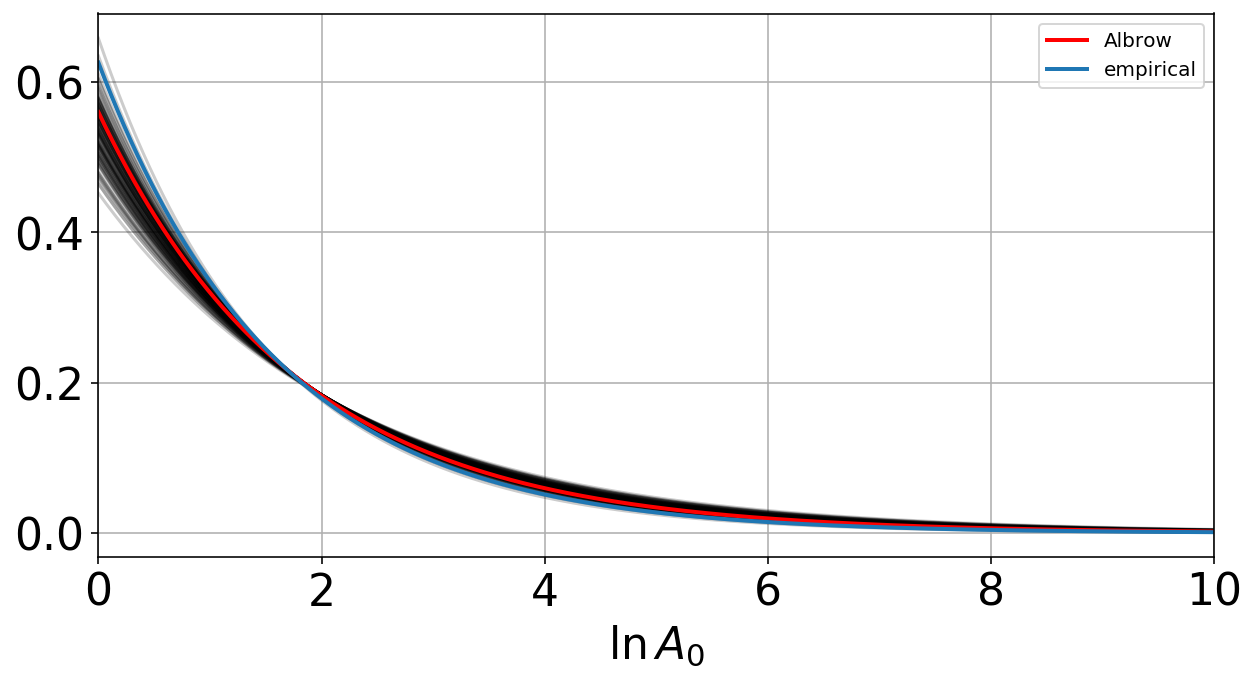

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.linspace(0., 10., 5000)

for mu in samples_hyper[:, 0][np.random.randint(len(samples_hyper), size=100)]:
    plot = mu*np.exp(-mu*x)
    ax.plot(x, plot, color='black', alpha=0.2)
    
# Plot distribution quoted in Albrow's paper 
mu_albrow = 1.289
ax.plot(x, mu_albrow*np.exp(-mu_albrow*x*np.log10(np.exp(1)))*np.log10(np.exp(1)),
        color='red', lw=2., label='Albrow')

# Plot distribution fitted to histogram
ax.plot(x, lam_ln_A0*np.exp(-lam_ln_A0*x), color='C0', lw=2., label='empirical')

ax.legend()
ax.grid()
ax.set_xlabel(r'$\ln\,A_0$')
ax.set_xlim(0, 10)

Text(0.5, 0, '$\\ln\\Delta t_0$')

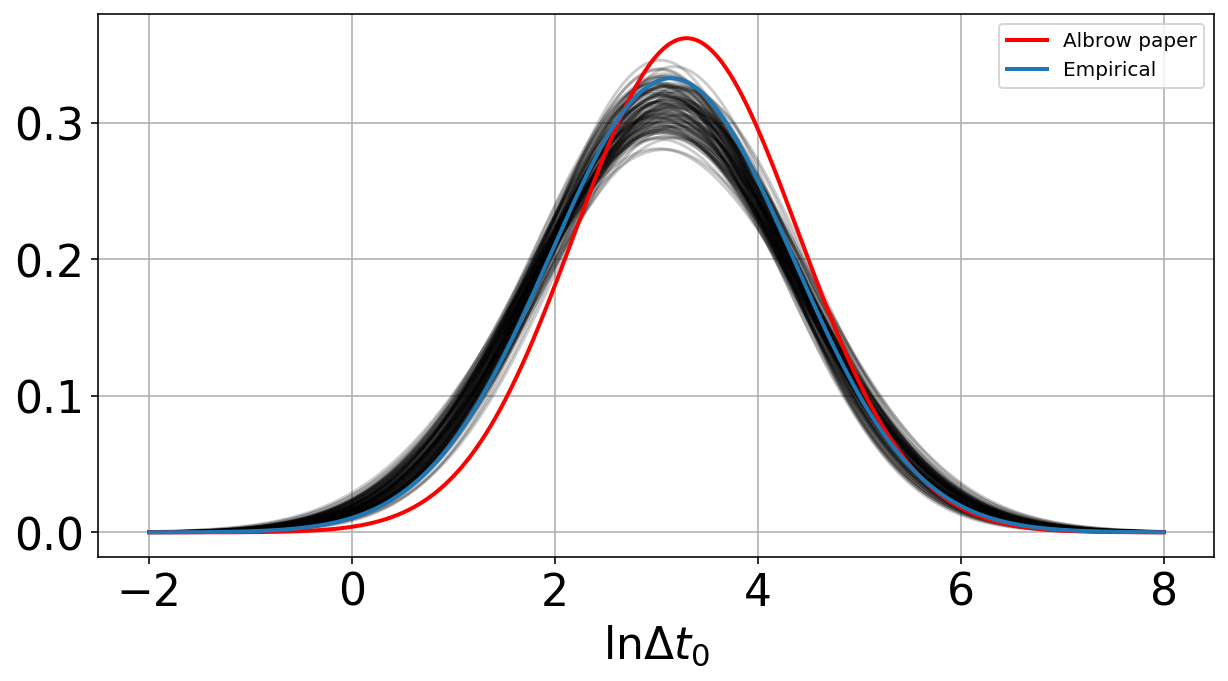

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.linspace(-2., 8, 5000)

for mu, sig in samples_hyper[:, 1:3][np.random.randint(len(samples_hyper), size=100)]:
    plot = scipy.stats.norm.pdf(x, mu, sig)
    ax.plot(x, plot, color='black', alpha=0.2)

# Plot distribution quoted in Albrow's paper
mu_albrow = 1.432
sig_albrow = np.sqrt(0.458/2)
ax.plot(x, np.log10(np.exp(1))*scipy.stats.norm.pdf(x*np.log10(np.exp(1)), mu_albrow, sig_albrow), 
        color='red', lw=2., label='Albrow paper')

# Plot distribution fitted to histogram
ax.plot(x, scipy.stats.norm.pdf(x, mu_ln_delta_t0, sig_ln_delta_t0), color='C0', lw=2., label='Empirical')

ax.legend()
ax.grid()
ax.set_xlabel(r'$\ln\Delta t_0$')

Text(0.5, 0, '$\\ln\\,t_E$')

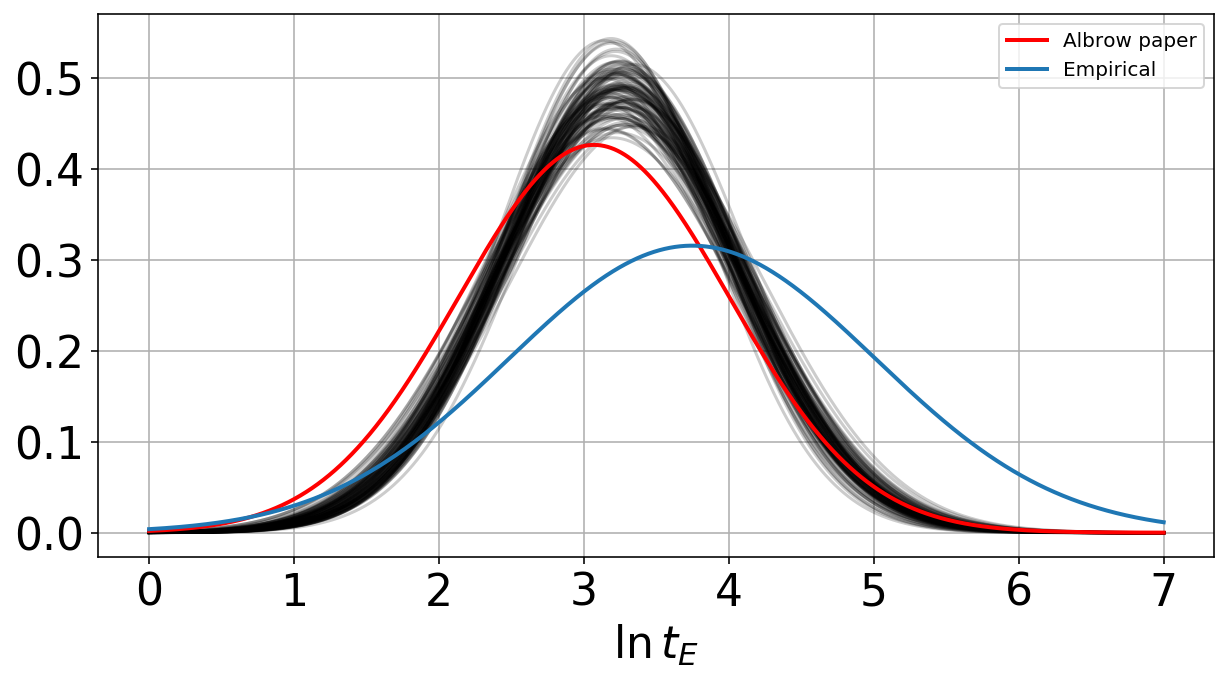

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.linspace(0., 7, 5000)

for mu, sig in samples_hyper[:, 3:5][np.random.randint(len(samples_hyper), size=100)]:
    plot = scipy.stats.norm.pdf(x, mu, sig)
    ax.plot(x, plot, color='black', alpha=0.2)
    
# Plot distribution quoted in Albrow's paper
mu_albrow = 1.333
sig_albrow = np.sqrt(0.33/2)
ax.plot(x, np.log10(np.exp(1))*scipy.stats.norm.pdf(x*np.log10(np.exp(1)), mu_albrow, sig_albrow),
        color='red', lw=2., label='Albrow paper')

# Plot distribution fitted to histogram
ax.plot(x, scipy.stats.norm.pdf(x, mu_ln_tE, sig_ln_tE), color='C0', lw=2., label='Empirical')

ax.grid()
ax.legend()
ax.set_xlabel(r'$\ln\,t_E$')
# ax.set_xlim(-10, 20)
# ax.set_ylim(0, 0.5)

(0, 20)

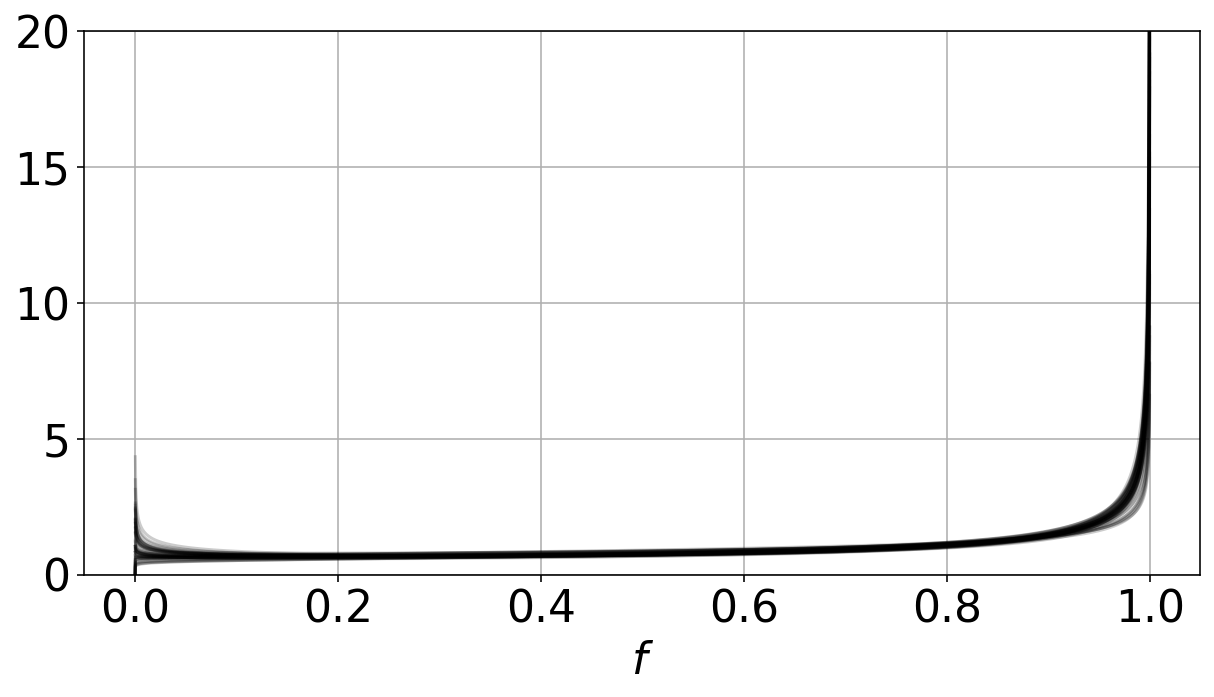

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.linspace(0., 1., 5000)

for alpha, beta in samples_hyper[:, 5:7][np.random.randint(len(samples_hyper), size=50)]:
    plot = scipy.stats.beta.pdf(x, alpha, beta)
    ax.plot(x, plot, color='black', alpha=0.2)   

ax.grid()
ax.set_xlabel(r'$f$')
# ax.set_xlim(0, 1)
ax.set_ylim(0, 20)